In [1]:
import pandas as pd, psycopg2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def query_database(connection, sql, *args, **kwargs):
    if connection.get_transaction_status() == 3:
        connection.reset()
    with connection.cursor() as cursor:
        cursor.execute(sql, *args, **kwargs)
        rows = cursor.fetchall()
        columns = [d[0] for d in cursor.description]
    df = pd.DataFrame(rows, columns=columns)
    return df

In [3]:
connection = psycopg2.connect('postgres://fga@localhost/fga')

In [4]:
sql = 'select * from devices limit 10'
df = query_database(connection, sql)
df.head()

,Id,DeviceId,DeviceName,DeviceMan,DeviceOS,DeviceOSVer,AppVersion,UserID,UserProfileID,Version,CreatedAt,UpdatedAt,Deleted,DeviceSerial,DeviceIsVirtual,DeviceUDID,OtherID1,OtherID1Previous,SimDeviceId
0,5FFC68A4-B539-4652-85FD-C062F96B2F6C,6daac5cb0706b620,Gemini Pro,Ulefone,Android,7.1.1,WEB_BROWSERx,D038FF0A-7930-44D9-9B90-3B1D4B01B653,EDFFC601-0C87-40B4-9AB0-A55B4D654AAE,\x0000000000751ec2,2018-01-14 08:31:54.6055341 +00:00,2019-01-18 12:37:42.0871351 +00:00,False,None,False,unknown,b65b676bc8d3e1e383704e97e7d812d1,b65b676bc8d3e1e383704e97e7d812d1,unknown
1,07E923A7-2F91-4F27-931B-675162C31881,a907b79f3bc2d8b8,Nexus 5X,LGE,Android,8.1.0,0.9.1,3876B0EB-D7AB-4FF0-B2C6-3071EE7E3185,35842A1B-C1C8-4A6D-8077-8D5AB72D84F3,\x0000000000005431,2018-01-14 08:42:20.3325653 +00:00,2018-01-14 08:42:20.3325653 +00:00,False,None,False,None,None,None,None
2,E44CF7F4-FF2C-4AE3-BCAA-FF0ECC51AB74,000000000000000011,SM-G920F,samsung,Android,7.0,0.9.1,431B96BA-33C0-4CE0-AE52-83426516F4BB,F03CE291-1AD2-42EE-9070-C38BB2A91C03,\x0000000000714ee9,2018-01-14 12:27:31.8089144 +00:00,2018-08-03 17:16:26.7197938 +00:00,False,None,False,None,None,None,None
3,B81614A3-1102-4DA8-B57F-341BBCFE7CE3,42ac18025c7c4b85,A0001,OnePlus,Android,6.0.1,0.9.1,A7E162D3-6983-45CB-898D-A97CF86D4053,CB492FB3-168F-47BD-BC7A-1A4DE6366C96,\x0000000000005676,2018-01-14 12:30:47.5445520 +00:00,2018-01-14 12:30:47.5445520 +00:00,False,None,False,None,None,None,None
4,1F81EEDF-D6FA-400D-B280-65498E2D1E9F,1bb88d070b2f3e90,WAS-LX1A,HUAWEI,Android,7.0,0.9.1,70BC4E78-C564-450D-BD2B-F4FC27B4DE06,CE563208-2F79-48E4-9DED-F158BC85FB51,\x00000000000056a6,2018-01-14 12:48:12.7965903 +00:00,2018-01-14 12:48:12.7965903 +00:00,False,None,False,None,None,None,None


In [5]:
sql = '''
with events_ as (
    select
        "createdAt" as ts,
        "currentUser" as user_id,
        "userDevice" as device_id
        
    from 
    
    events
    
), users_ as (
    select
        "Id" as user_id,
        "CreatedAt" as created_at
        
    from users
    
), devices_ as (
    select
        "Id" as device_id,
        "DeviceOS" as client
        
    from devices
    
), results as (
    select
        ts::date as date,
        client,
        case when
            events_.ts::date = users_.created_at::date then 'new'
            else 'existing'
        end as tenure_type,
        count(distinct user_id) as dau
        
    from events_ join users_ using (user_id)
        join devices_ using (device_id)
    
    group by 1, 2, 3
    
    order by 1, 2, 3

)

select * from results
'''

df = query_database(connection, sql)
df.head()

,date,client,tenure_type,dau
0,2019-10-14,Android,existing,440
1,2019-10-14,Android,new,21
2,2019-10-14,iOS,existing,307
3,2019-10-14,iOS,new,30
4,2019-10-15,Android,existing,399


In [6]:
df

,date,client,tenure_type,dau
0,2019-10-14,Android,existing,440
1,2019-10-14,Android,new,21
2,2019-10-14,iOS,existing,307
3,2019-10-14,iOS,new,30
4,2019-10-15,Android,existing,399
5,2019-10-15,Android,new,8
6,2019-10-15,iOS,existing,318
7,2019-10-15,iOS,new,16
8,2019-10-16,Android,existing,269
9,2019-10-16,Android,new,6


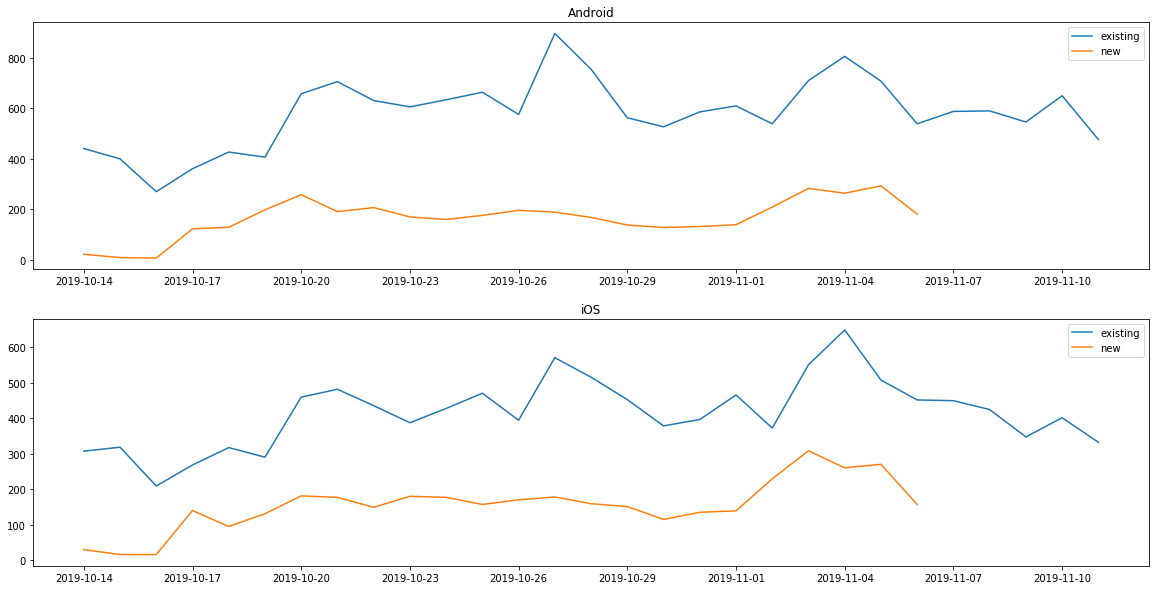

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
for i, (client, df_) in enumerate(df.groupby('client')):
    ax = axes[i]
    for (tenure_type, df__) in df_.groupby('tenure_type'):
        ax.plot(df__['date'], df__['dau'], label=tenure_type)
    ax.legend()
    ax.set_title(client)